# Sandbox for the model speaks

trying to get plot code to work

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from the_model_speaks import *

In [58]:
NUM_ITERS = 8
NUM_TOKENS = 2

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

wandb.init(project="parallel_transformer")
param_file = "../model_files/proto_params.json"

with open(param_file, "r") as f:
    model_args = ModelArgs(**json.loads(f.read()))

model = Transformer(
    model_args, key=jax.random.PRNGKey(1), dtype=jnp.float32
)  

# cache_k = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)
# cache_v = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)

# tokenizer = Tokenizer("../model_files/tokenizer.model")

# # seq generation
# res_seq, gen_seq, seq_logits, seq_finals = generate(
#     model,
#     tokenizer,
#     cache_k,
#     cache_v,
#     model_args.head_dim,
#     max_tokens=NUM_TOKENS,
#     parallel=False,
#     prefill=False,
# )
# print(f"the output of sequential is : {res_seq}")
# print(f"the generated tokens from sequential is : {gen_seq}")

# # parr generation
# res_parr, gen_parr, parr_logits, parr_finals = generate(model, tokenizer, cache_k, cache_v, model_args.head_dim, max_tokens=NUM_TOKENS, parallel=True, num_iters=NUM_ITERS, prefill=False)
# print(f"the output of parallel is : {res_parr}")
# print(f"the genrated tokens from parallel is : {gen_parr}")



Using device: cpu


In [60]:
parr_finals[0].squeeze().shape

(32, 64)

In [61]:
parr_finals[0].squeeze()[-1][None,...].shape

(1, 64)

In [62]:
seq_finals[0].squeeze()[None, ...].shape

(1, 32, 64)

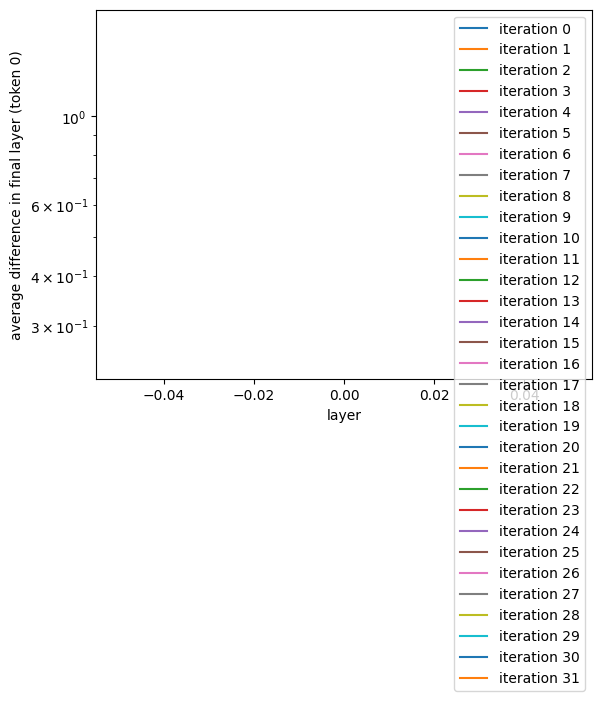

In [63]:
# converging...but to the wrong target :( 
tok_num = 0
diffs = jnp.mean(
    jnp.abs(parr_finals[0].squeeze()[-1][None, ...] - parr_finals[tok_num].squeeze()),
    axis=(-1),
)
for i in range(len(diffs)):
    plt.plot(diffs[i], label=f"iteration {i}")
plt.legend()
plt.xlabel("layer")
plt.ylabel(f"average difference in final layer (token {tok_num})")
plt.yscale("log")

In [64]:
type(model)

the_model_speaks.Transformer

In [65]:
cos_freq, sin_freq = precompute_frequencies(8, 128000)
pos = jnp.array([0])
h0 = jr.normal(jr.PRNGKey(0), shape=(1,64))
cache_k = jr.normal(
    jr.PRNGKey(0),
    (
        model_args.max_batch_size,
        model_args.n_layers,
        model_args.sliding_window,
        model_args.n_kv_heads,
        model_args.head_dim,
    ),
    dtype=jnp.float32,
)
cache_v = cache_k.copy()

In [66]:
IDX = 0
out_full, _, _ = model.layers[IDX](h0, cos_freq[pos], sin_freq[pos], pos, None, cache_k[0,IDX], cache_v[0,IDX])

> /Users/xaviergonzalez/Desktop/xavier_folders/stanford/cs229s/mistral_jax/mistral_jax/the_model_speaks.py(306)__call__()
    304     def __call__(self, x, cos_freq, sin_freq, positions, mask, cache_k, cache_v):
    305         pdb.set_trace()
--> 306         normed_x = jax.vmap(self.attention_norm)(x)
    307         r, cache_k, cache_v = self.attention(
    308             normed_x, cos_freq, sin_freq, positions, mask, cache_k, cache_v

[[0.29424262 0.85110813]
 [0.75408727 1.0855358 ]]



In [67]:
partial_layers = model.partial_layers(
    model.layers,
    cos_freq[pos],
    sin_freq[pos],
    pos,
    None,
    cache_k[0],
    cache_v[0]
)

In [69]:
out_part = partial_layers[IDX](h0)


> /Users/xaviergonzalez/Desktop/xavier_folders/stanford/cs229s/mistral_jax/mistral_jax/the_model_speaks.py(306)__call__()
    304     def __call__(self, x, cos_freq, sin_freq, positions, mask, cache_k, cache_v):
    305         pdb.set_trace()
--> 306         normed_x = jax.vmap(self.attention_norm)(x)
    307         r, cache_k, cache_v = self.attention(
    308             normed_x, cos_freq, sin_freq, positions, mask, cache_k, cache_v

*** SyntaxError: '(' was never closed
[[0.29424262 0.85110813]
 [0.75408727 1.0855358 ]]



In [ ]:
jnp.argmin(cache_k-2.2798064)

Array(2390258, dtype=int32)

In [ ]:
jnp.where(cache_k == 2.2798064)

(Array([0], dtype=int32),
 Array([31], dtype=int32),
 Array([6], dtype=int32),
 Array([0], dtype=int32),
 Array([0], dtype=int32))

In [ ]:
cache_k[0, 31, 6, :2, :2]

Array([[ 2.2798064, -0.9056061],
       [-0.198327 ,  1.1769187]], dtype=float32)

In [ ]:
cache_k[0, 30, 6, :2, :2]

Array([[ 0.10780615, -0.6220313 ],
       [-1.2680752 , -0.66429436]], dtype=float32)

In [ ]:
cache_k[0, 1, 6, :2, :2]

Array([[ 0.8470511 ,  0.82570654],
       [-0.38995418, -0.5054998 ]], dtype=float32)

In [ ]:
cache_k[0, 0, 6, :2, :2]

Array([[0.29424262, 0.85110813],
       [0.75408727, 1.0855358 ]], dtype=float32)